In [1]:
#!pip install wordcloud
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
data=pd.read_csv("ds_salaries.csv")

In [3]:
print(data.shape)

(3755, 11)


In [4]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
data.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [6]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
data.duplicated().sum()

1171

In [8]:
data = data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

In [10]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [11]:
print(data['salary_in_usd'].unique())

[ 85847  30000  25500 ...  28369 412000  94665]


In [12]:

threshold = data['salary_in_usd'].median()

data['salary_binary'] = data['salary_in_usd'].apply(lambda x: 1 if x > threshold else 0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_binary
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,1
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0


In [13]:
numerical_columns=data.select_dtypes(include=['int64']).columns
categorical_columns=data.select_dtypes(include=['object']).columns

In [14]:
numerical_columns

Index(['work_year', 'salary', 'salary_in_usd', 'remote_ratio',
       'salary_binary'],
      dtype='object')

In [15]:
categorical_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [16]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio,salary_binary
count,2584.000000,2.584000e+03,2584.000000,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746,0.485681
std,0.749179,8.080375e+05,67136.837329,48.163707,0.499892
min,2020.000000,6.000000e+03,5132.000000,0.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000,0.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000,1.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000,1.000000


In [17]:
iso_forest=IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(data[numerical_columns])
outlier_count = (outliers == -1).sum()
total_count = len(outliers)
outlier_percentage = (outlier_count / total_count) * 100
print(f"Percentage of numerical outliers: {outlier_percentage:.2f}%")

Percentage of numerical outliers: 5.03%


C:\Users\nipun\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [18]:
cat_outliers = {}
cat_outlier_count = 0

for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outliers[col] = rare_categories.index.tolist()
    cat_outlier_count += data[col].isin(rare_categories.index).sum()

total_count = len(data)

categorical_outlier_percentage = (cat_outlier_count / total_count) * 100

print(f"Categorical outliers count: {cat_outlier_count}")
print(f"Categorical outliers percentage: {categorical_outlier_percentage:.2f}%")

Categorical outliers count: 2153
Categorical outliers percentage: 83.32%


In [19]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

data['job_category'] = data['job_title'].apply(assign_broader_category)


In [20]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_binary,job_category
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0,Other
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0,Machine Learning
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0,Machine Learning
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,1,Data Science
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0,Data Science


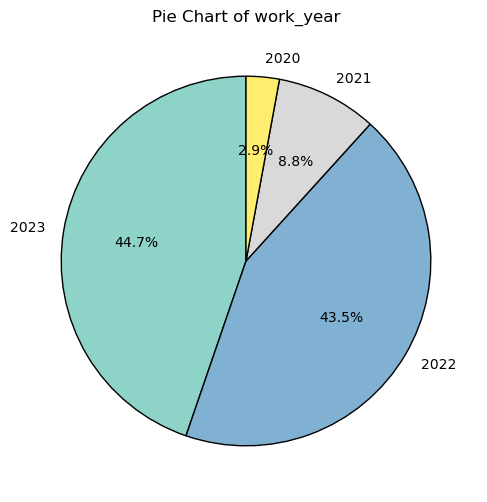

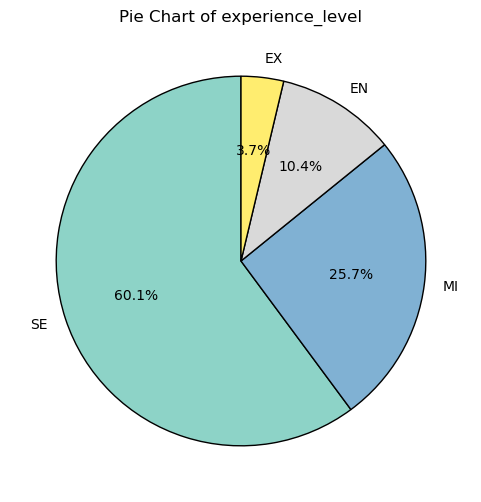

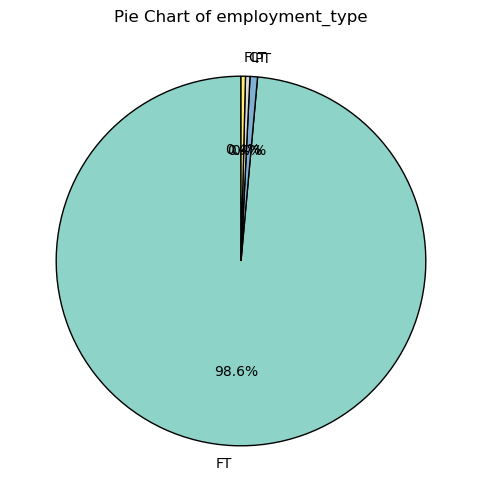

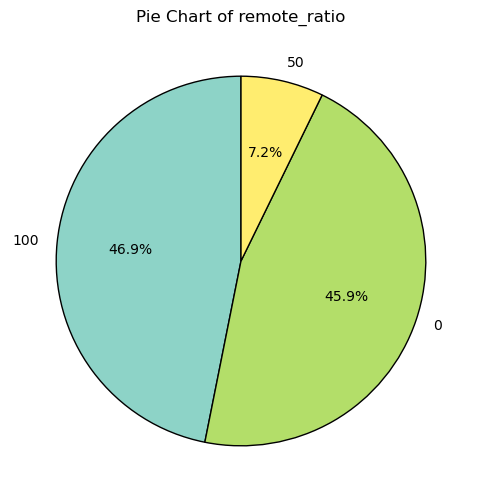

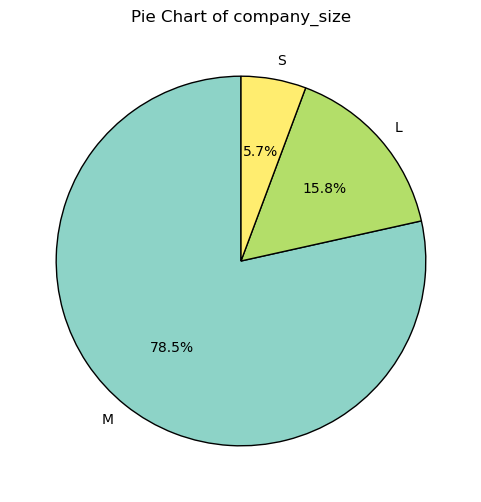

In [21]:
for col in ['work_year','experience_level','employment_type','remote_ratio','company_size']:
    plt.figure(figsize=(6, 6))
    data[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', wedgeprops={'edgecolor': 'black'})
    plt.title(f"Pie Chart of {col}")
    plt.ylabel('')  # Remove the y-label for clarity
    plt.show()

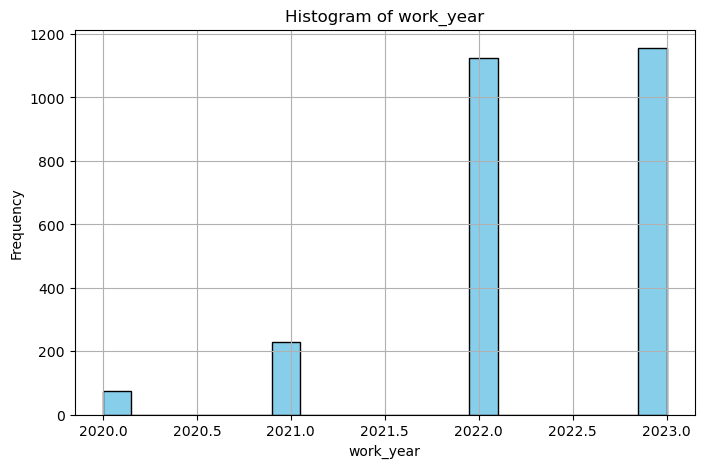

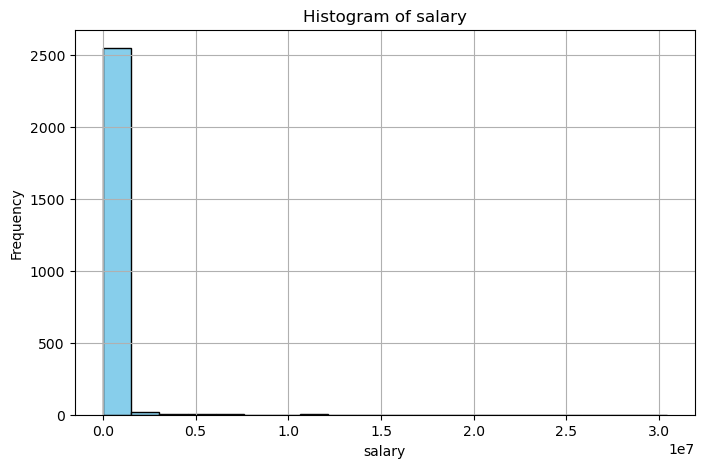

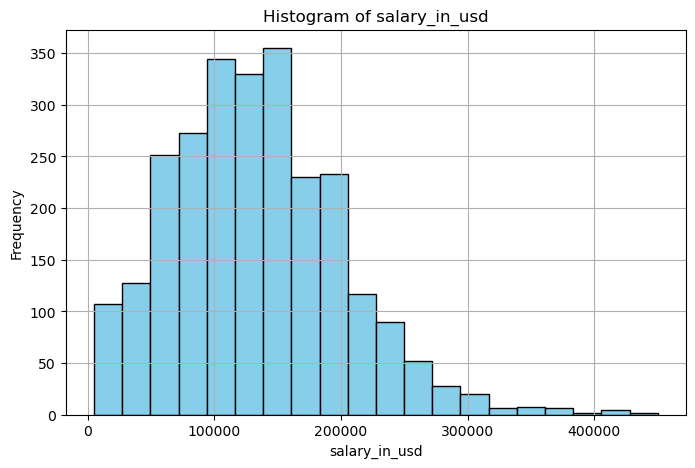

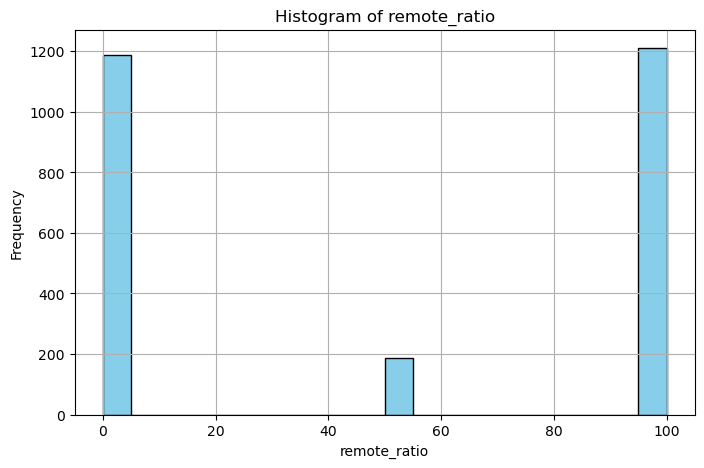

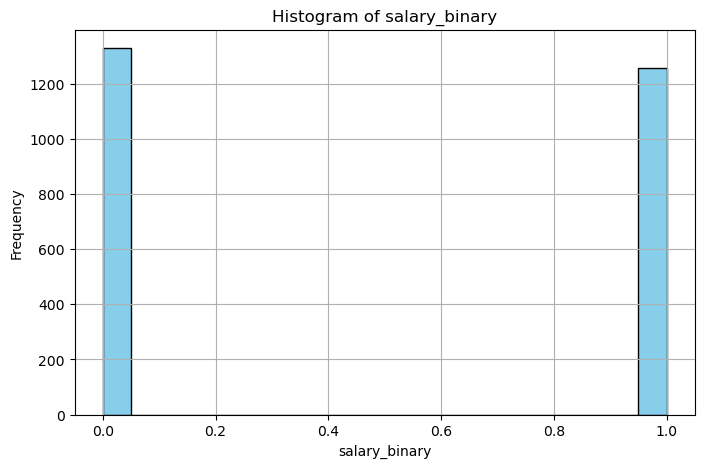

In [22]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

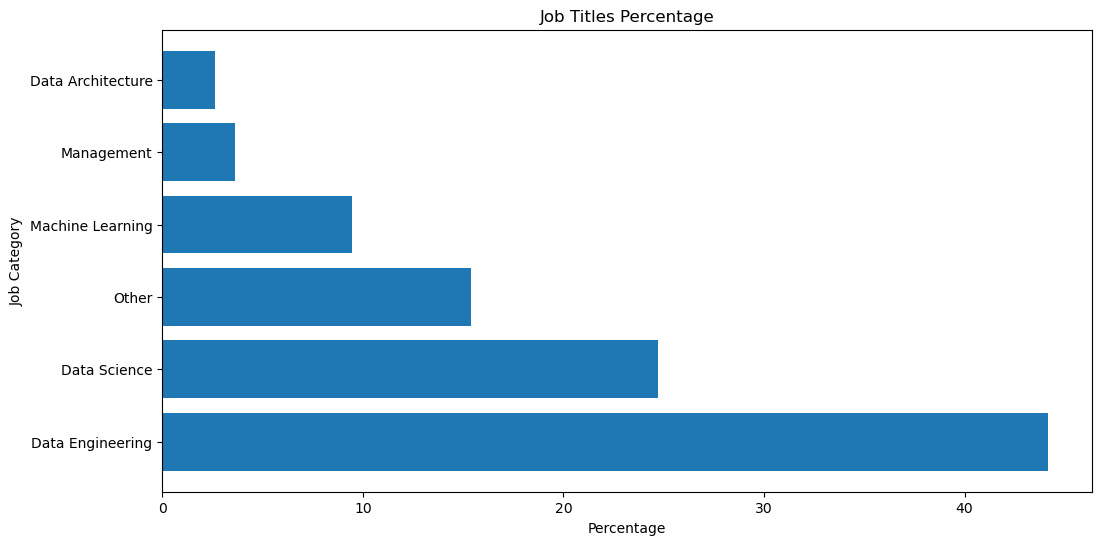

In [23]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

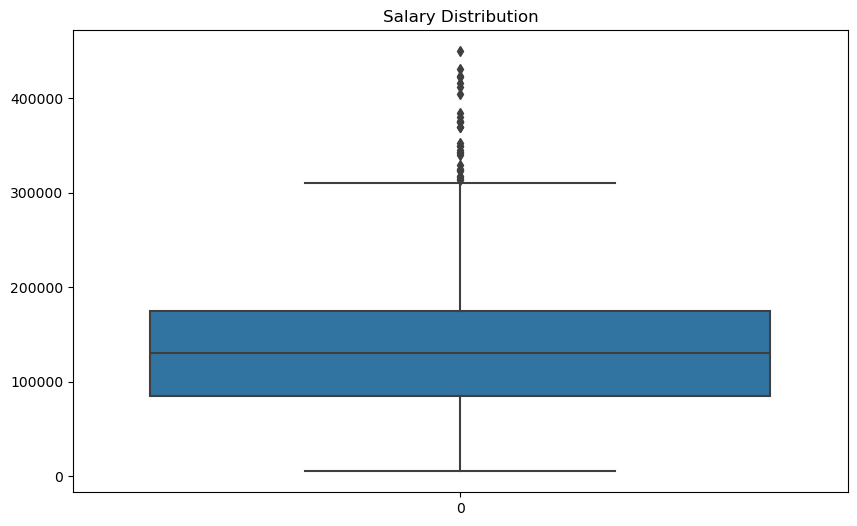

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data['salary_in_usd'])
plt.title('Salary Distribution')
plt.show()

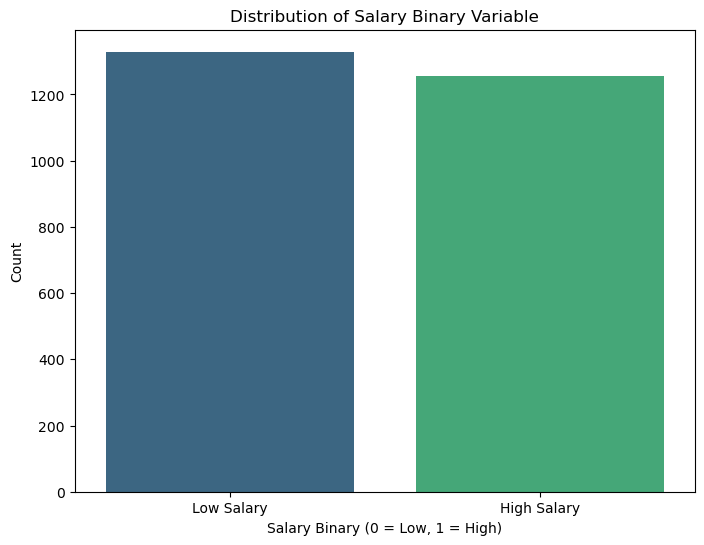

In [25]:
salary_counts = data['salary_binary'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=salary_counts.index, y=salary_counts.values, palette='viridis')
plt.xlabel('Salary Binary (0 = Low, 1 = High)')
plt.ylabel('Count')
plt.title('Distribution of Salary Binary Variable')
plt.xticks([0, 1], ['Low Salary', 'High Salary'])
plt.show()

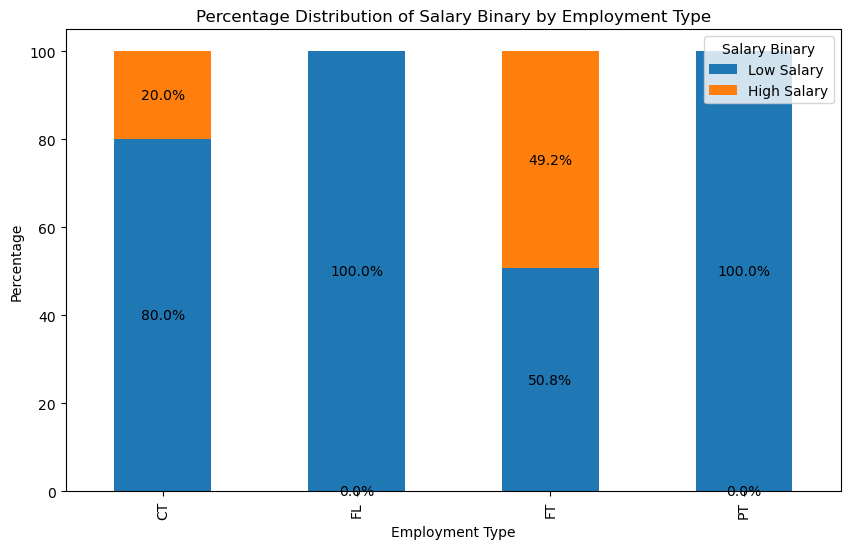

In [26]:
df_grouped = data.groupby(['employment_type', 'salary_binary']).size().unstack()
df_percentage = df_grouped.apply(lambda x: x / x.sum() * 100, axis=1)


ax = df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Employment Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Salary Binary by Employment Type')
plt.legend(title='Salary Binary', labels=['Low Salary', 'High Salary'], loc='upper right')

# Add percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.show()


C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='salary_in_usd', ylabel='Count'>

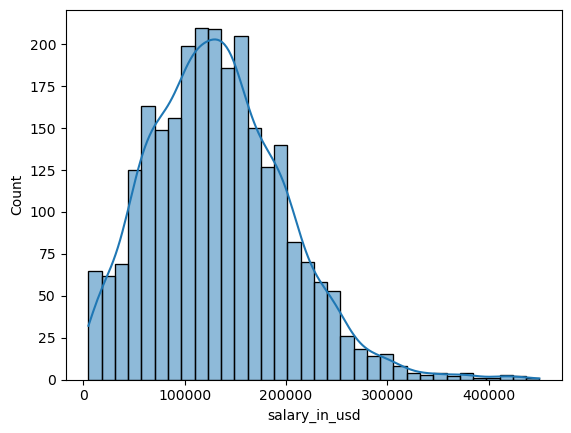

In [27]:
sns.histplot(data['salary_in_usd'], kde=True)

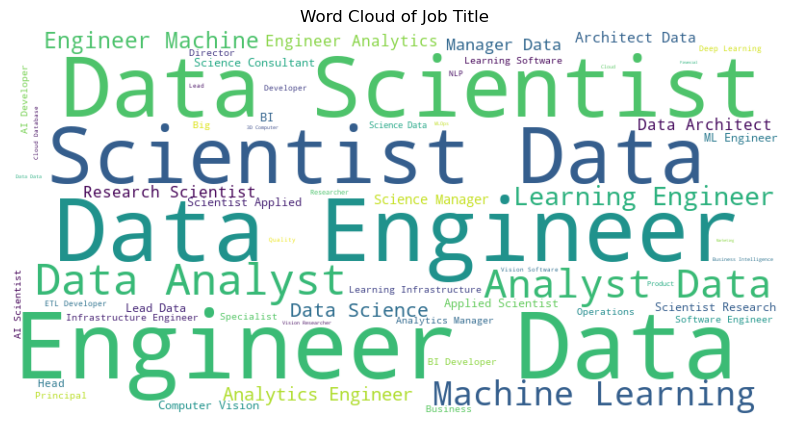

In [28]:
text_data = ' '.join(data['job_title'].dropna())  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud of Job Title')
plt.show()

C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


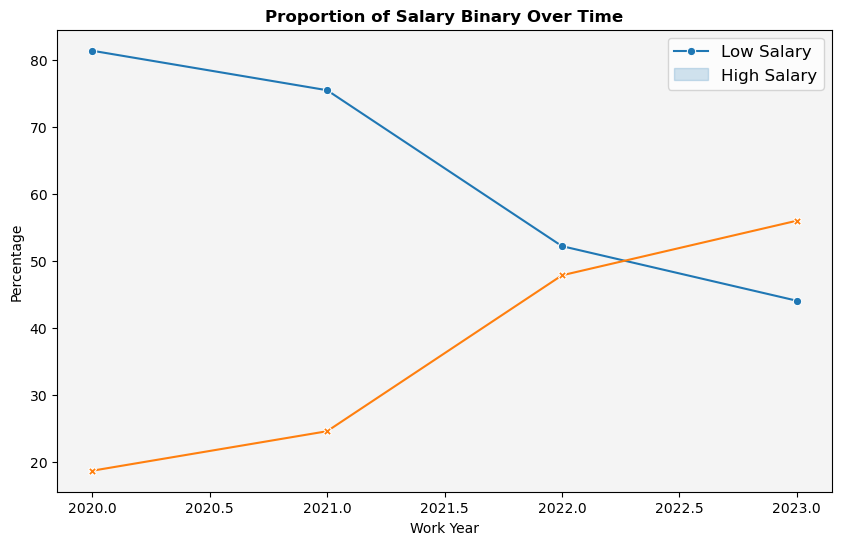

In [29]:
salary_trend = data.groupby(['work_year', 'salary_binary']).size().unstack()
salary_trend = salary_trend.apply(lambda x: x / x.sum() * 100, axis=1)  # Convert counts to percentages

plt.figure(figsize=(10, 6))
p = sns.lineplot(data=salary_trend, markers=True, dashes=False)

plt.title('Proportion of Salary Binary Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Work Year')
plt.ylabel('Percentage')
p.set_facecolor("#f4f4f4")
plt.legend(['Low Salary', 'High Salary'], loc='best', fontsize=12)
plt.grid(False)
plt.show()


C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nipun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


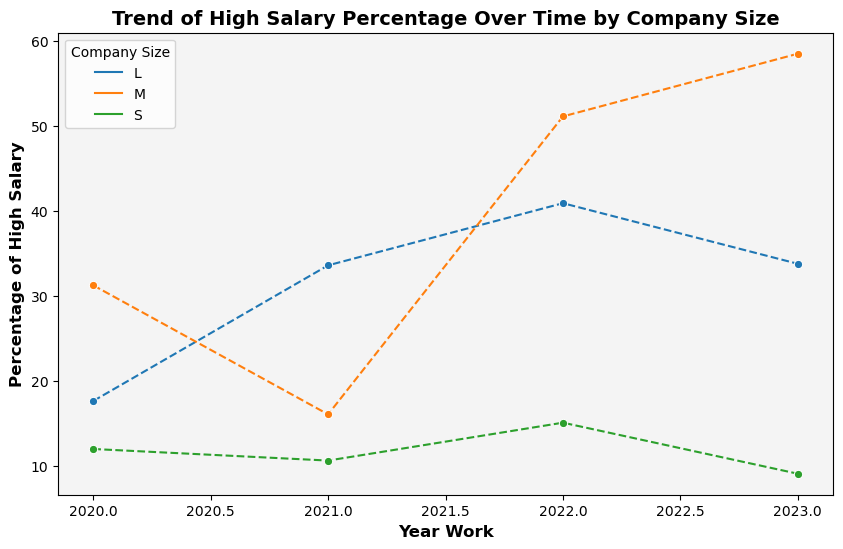

In [30]:
salary_trend = data.groupby(['work_year', 'company_size', 'salary_binary']).size().unstack()
salary_trend = salary_trend.apply(lambda x: x / x.sum() * 100, axis=1)  # Convert counts to percentages

salary_trend = salary_trend.reset_index()

plt.figure(figsize=(10, 6))
p = sns.lineplot(data=salary_trend, x='work_year', y=1, hue='company_size', marker='o', linestyle='--')

plt.xlabel('Year Work', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of High Salary', fontsize=12, fontweight='bold')
plt.title('Trend of High Salary Percentage Over Time by Company Size', fontsize=14, fontweight='bold')

plt.legend(title='Company Size', title_fontsize=10, fontsize=10, loc='upper left')
p.set_facecolor("#f4f4f4")
p.grid(False)
plt.show()


In [31]:
emp_salary = data.groupby('employment_type')['salary_in_usd'].mean()
emp_salary

employment_type
CT    113446.900000
FL     51807.800000
FT    134434.613271
PT     39533.705882
Name: salary_in_usd, dtype: float64

In [32]:
emp_salary1 = data.groupby('salary_currency')['salary_in_usd'].mean()
emp_salary1

salary_currency
AUD     74198.444444
BRL     12448.000000
CAD     96707.400000
CHF    100682.000000
CLP     40038.000000
CZK      5132.000000
DKK     31192.666667
EUR     64444.240000
GBP     84347.034722
HKD     65062.000000
HUF     29892.666667
ILS    423834.000000
INR     25993.644068
JPY     60921.333333
MXN     33511.000000
PLN     34165.200000
SGD     81770.000000
THB     27096.500000
TRY     20096.666667
USD    148499.630280
Name: salary_in_usd, dtype: float64

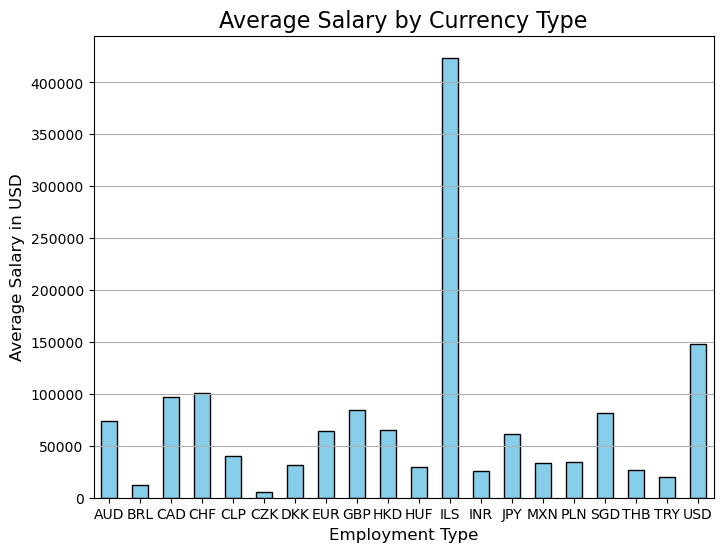

In [33]:
plt.figure(figsize=(8, 6))
emp_salary1.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Salary by Currency Type', fontsize=16)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Average Salary in USD', fontsize=12)

plt.xticks(rotation=0)  
plt.grid(axis='y')  
plt.show()

In [34]:
emp_salary2 = data.groupby('experience_level')['salary_in_usd'].mean()
emp_salary2

experience_level
EN     72648.685185
EX    191078.208333
MI    101828.783133
SE    153897.435650
Name: salary_in_usd, dtype: float64

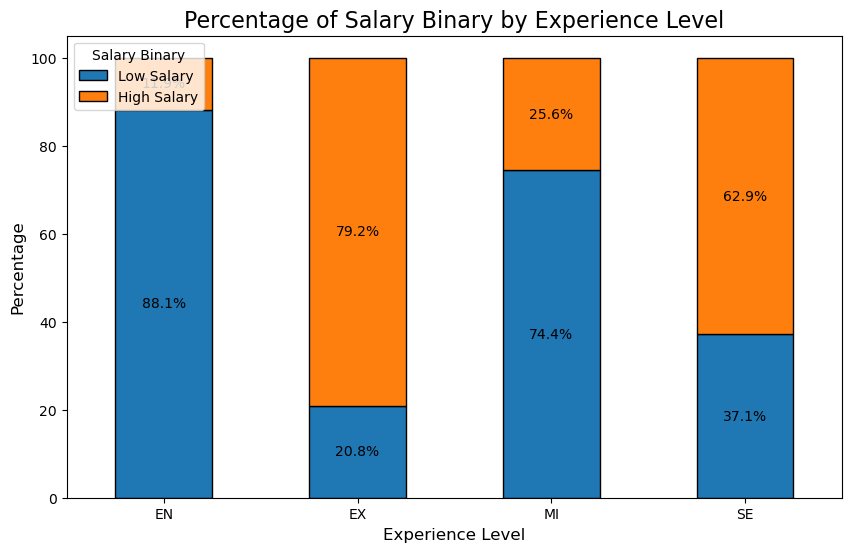

In [35]:
experience_salary = data.groupby(['experience_level', 'salary_binary']).size().unstack()
experience_salary = experience_salary.apply(lambda x: x / x.sum() * 100, axis=1)  # Convert counts to percentages
ax = experience_salary.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(10, 6), edgecolor='black')
plt.title('Percentage of Salary Binary by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Salary Binary', labels=['Low Salary', 'High Salary'], loc='upper left')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.xticks(rotation=0)
plt.show()


In [36]:
emp_salary3 = data.groupby('remote_ratio')['salary_in_usd'].mean()
emp_salary3

remote_ratio
0      143690.173693
50      78486.609626
100    131821.666391
Name: salary_in_usd, dtype: float64

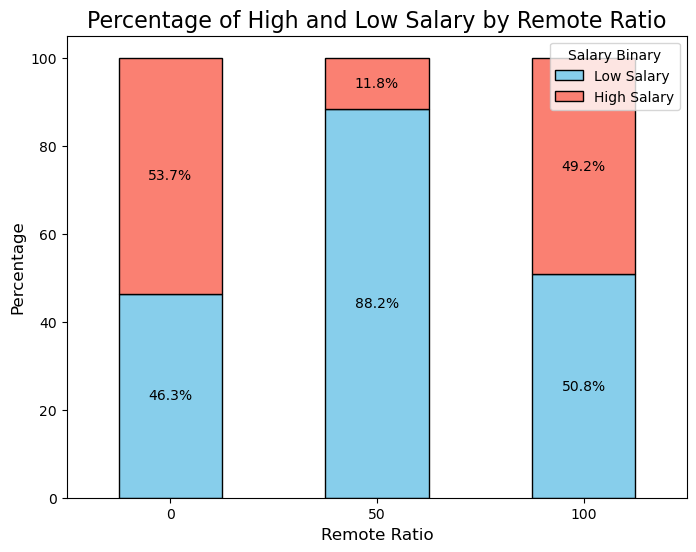

In [37]:
remote_salary = data.groupby(['remote_ratio', 'salary_binary']).size().unstack()
remote_salary = remote_salary.apply(lambda x: x / x.sum() * 100, axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
remote_salary.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], edgecolor='black', ax=ax)
plt.title('Percentage of High and Low Salary by Remote Ratio', fontsize=16)
plt.xlabel('Remote Ratio', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Salary Binary', labels=['Low Salary', 'High Salary'], loc='upper right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.xticks(rotation=0)
plt.show()


In [38]:
emp_salary4 = data.groupby('company_size')['salary_in_usd'].mean()
emp_salary4

company_size
L    113202.239609
M    141474.514300
S     78364.278912
Name: salary_in_usd, dtype: float64

<Figure size 1000x600 with 0 Axes>

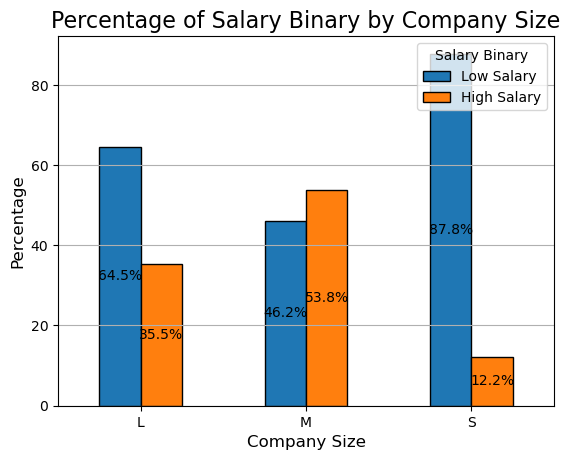

In [39]:
salary_counts = data.groupby(['company_size', 'salary_binary']).size().unstack()
salary_percentage = salary_counts.apply(lambda x: x / x.sum() * 100, axis=1)
plt.figure(figsize=(10, 6))
ax = salary_percentage.plot(kind='bar', stacked=False, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Percentage of Salary Binary by Company Size', fontsize=16)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Salary Binary', labels=['Low Salary', 'High Salary'], loc='upper right')

# Add percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [40]:
emp_salary5 = data.groupby('company_location')['salary_in_usd'].mean()
emp_salary5

company_location
AE    100000.000000
AL     10000.000000
AM     50000.000000
AR     25000.000000
AS     29351.000000
          ...      
TH     23064.333333
TR     19058.000000
UA     57850.000000
US    152374.791602
VN     12000.000000
Name: salary_in_usd, Length: 72, dtype: float64

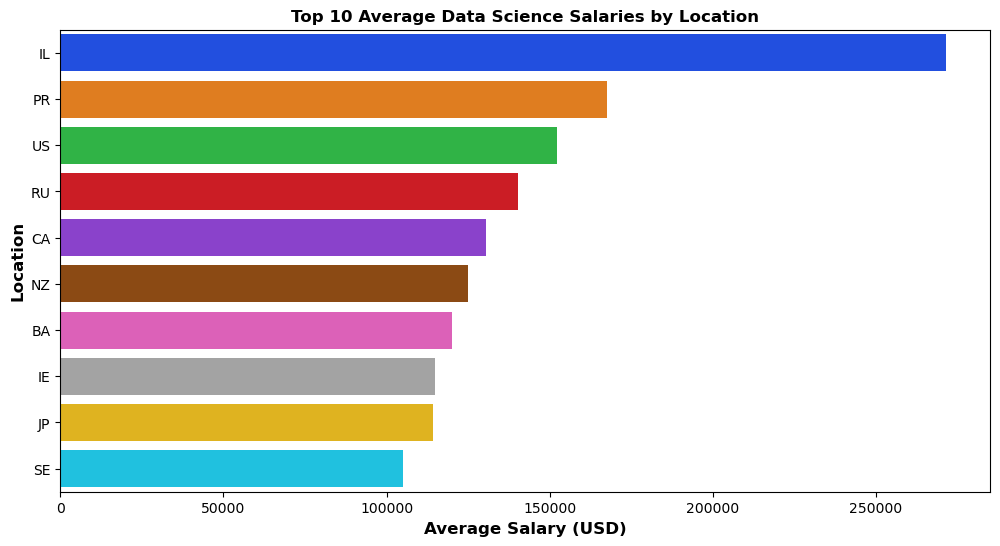

In [41]:
emp_salary5 = emp_salary5.sort_values(ascending=False)

emp_salary5_df = emp_salary5.reset_index()

top_n_locations = 10

plt.figure(figsize=(12, 6))
sns.barplot(x='salary_in_usd', y='company_location', data=emp_salary5_df.head(top_n_locations), palette='bright')

plt.title(f'Top {top_n_locations} Average Data Science Salaries by Location', fontsize=12, fontweight='bold')
plt.xlabel('Average Salary (USD)', fontsize=12, fontweight='bold')
plt.ylabel('Location', fontsize=12, fontweight='bold')

plt.show()


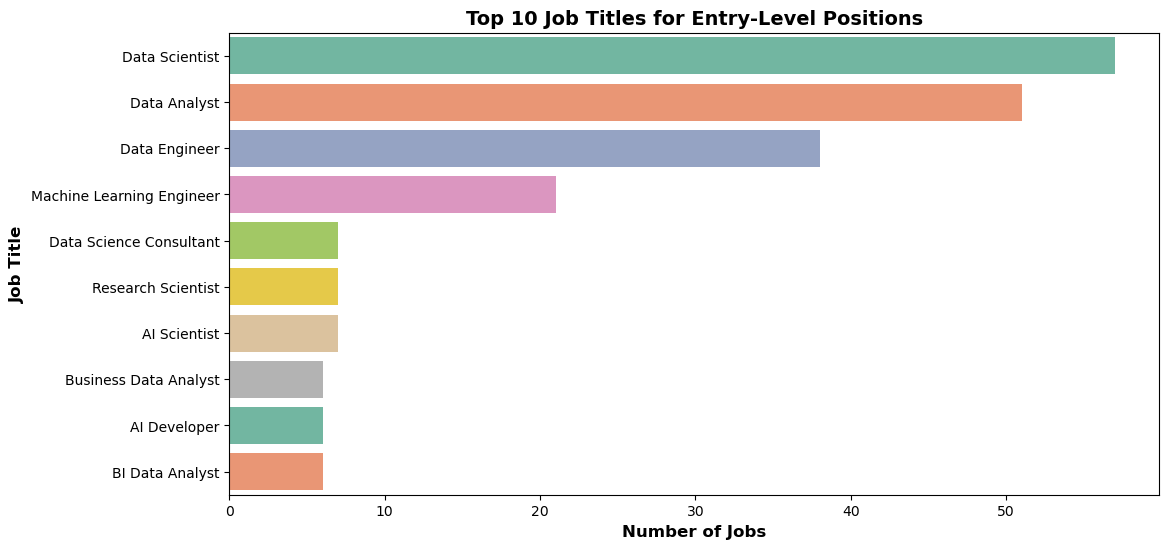

In [42]:
entry_level_jobs = data[data['experience_level'] == 'EN']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Entry-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

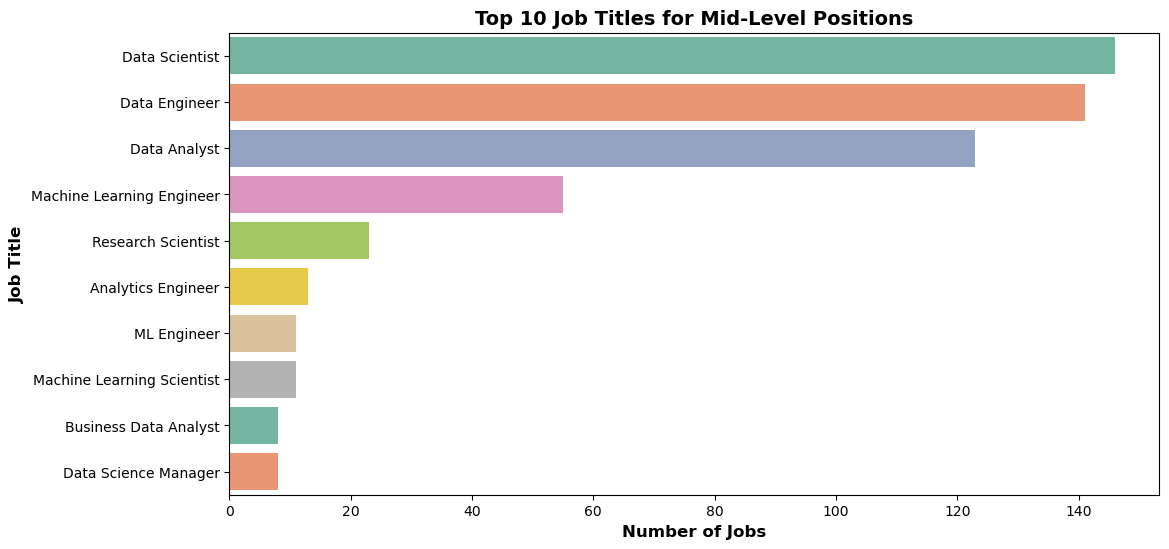

In [43]:
entry_level_jobs = data[data['experience_level'] == 'MI']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Mid-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

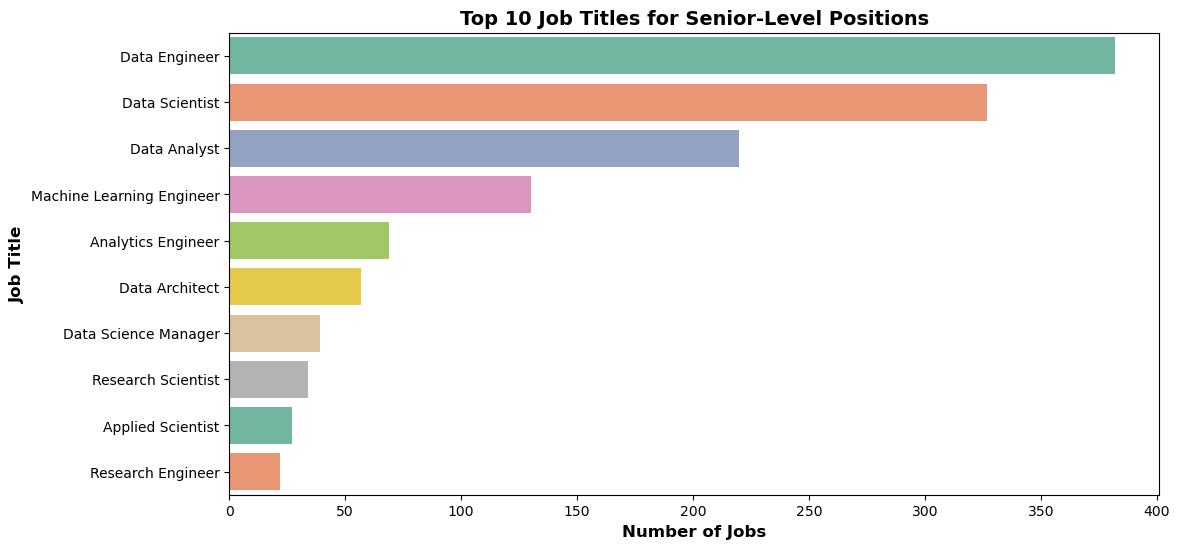

In [44]:
entry_level_jobs = data[data['experience_level'] == 'SE']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Senior-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

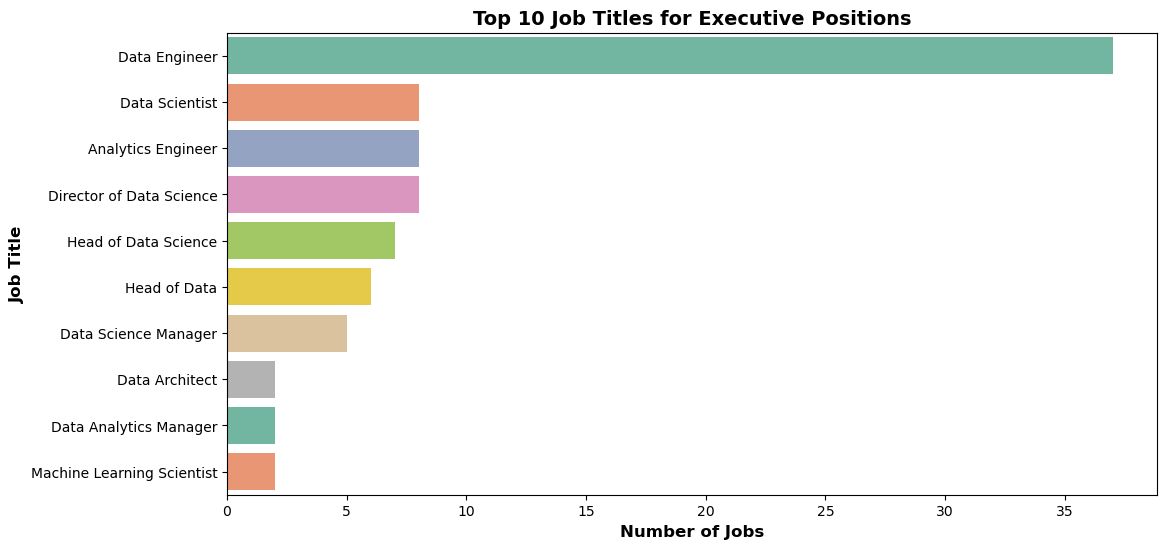

In [45]:
entry_level_jobs = data[data['experience_level'] == 'EX']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Executive Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

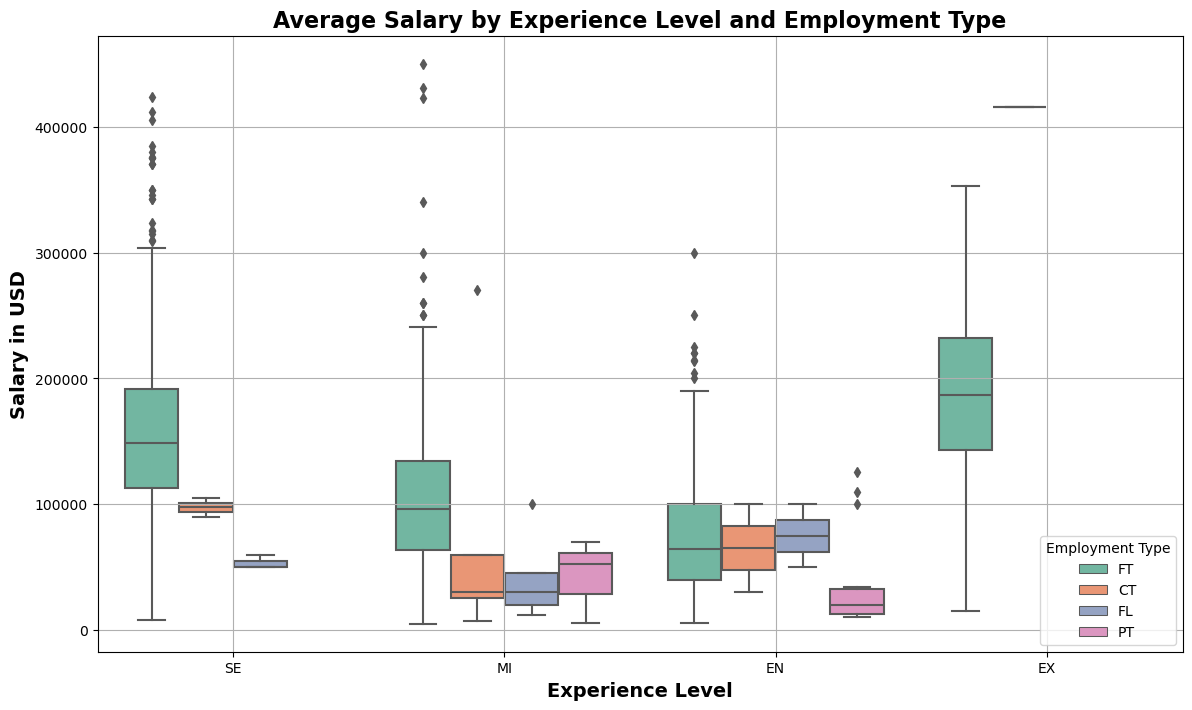

In [46]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='experience_level', y='salary_in_usd', hue='employment_type', data=data, palette='Set2')

plt.title('Average Salary by Experience Level and Employment Type', fontsize=16, fontweight='bold')
plt.xlabel('Experience Level', fontsize=14, fontweight='bold')
plt.ylabel('Salary in USD', fontsize=14, fontweight='bold')

plt.legend(title='Employment Type')
plt.grid(True)
plt.show()

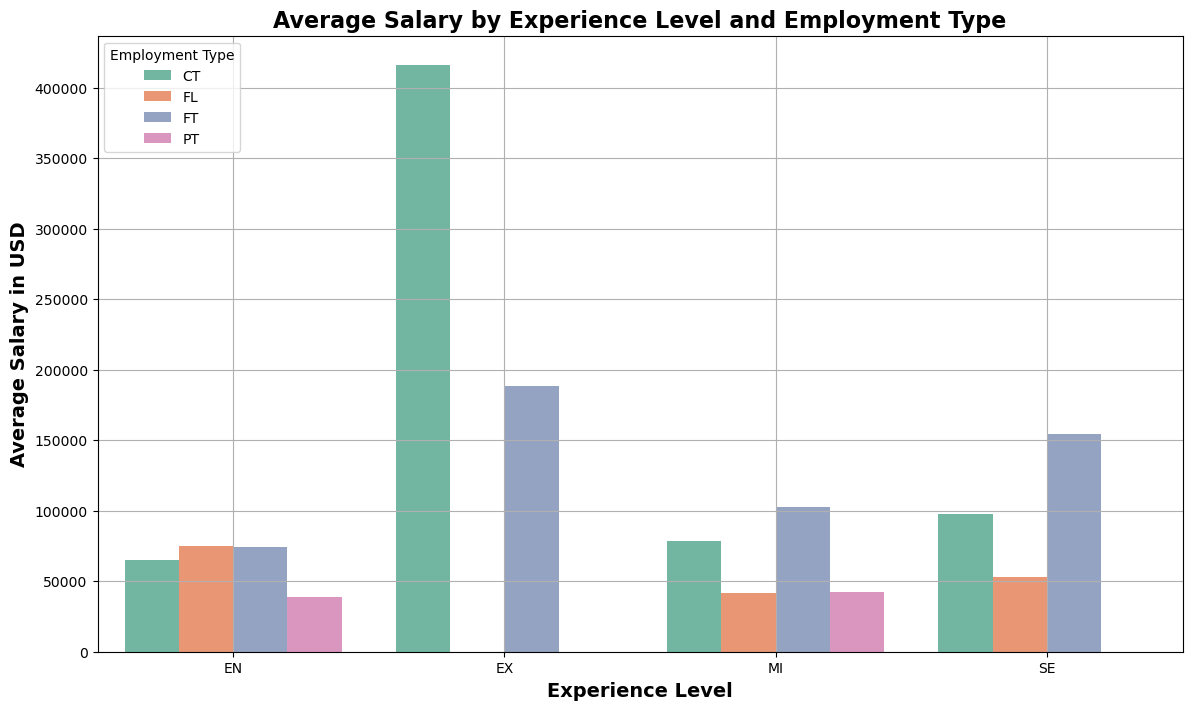

In [47]:
avg_salary = data.groupby(['experience_level', 'employment_type'])['salary_in_usd'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(x='experience_level', y='salary_in_usd', hue='employment_type', data=avg_salary, palette='Set2')

plt.title('Average Salary by Experience Level and Employment Type', fontsize=16, fontweight='bold')
plt.xlabel('Experience Level', fontsize=14, fontweight='bold')
plt.ylabel('Average Salary in USD', fontsize=14, fontweight='bold')

plt.legend(title='Employment Type')
plt.grid(True)
plt.show()

               work_year    salary  salary_in_usd  remote_ratio  salary_binary
work_year       1.000000 -0.099153       0.236958     -0.219160       0.191388
salary         -0.099153  1.000000      -0.043672      0.026485      -0.026260
salary_in_usd   0.236958 -0.043672       1.000000     -0.084502       0.788697
remote_ratio   -0.219160  0.026485      -0.084502      1.000000      -0.042726
salary_binary   0.191388 -0.026260       0.788697     -0.042726       1.000000


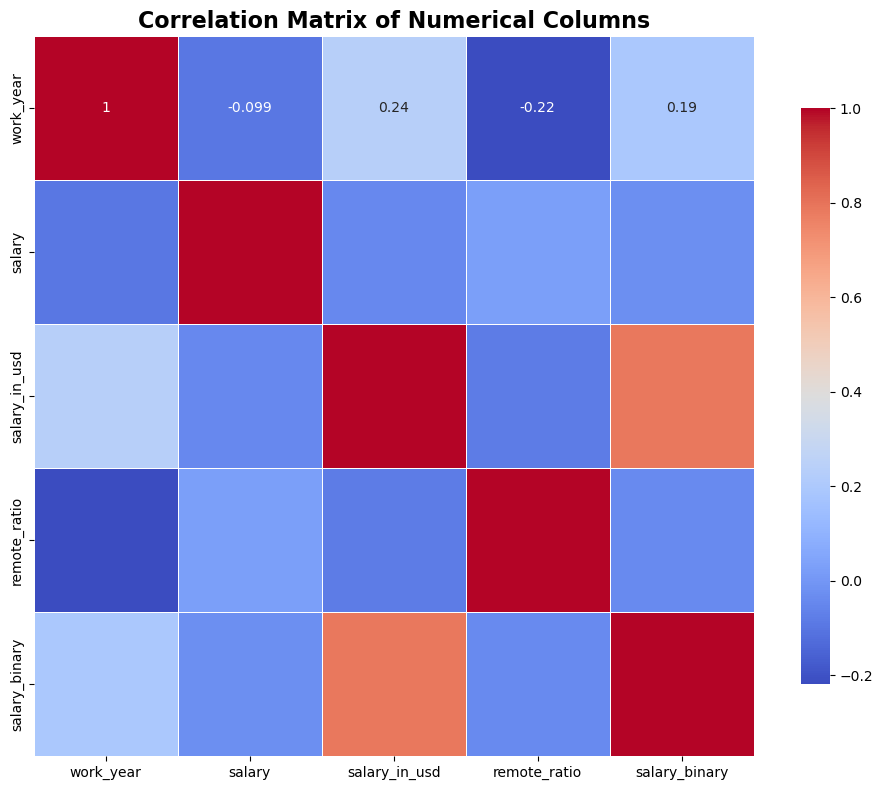

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns (int and float types)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_columns]

# Calculate the correlation matrix for numerical columns only
correlation_matrix = numerical_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix of Numerical Columns', fontsize=16, fontweight='bold')

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()



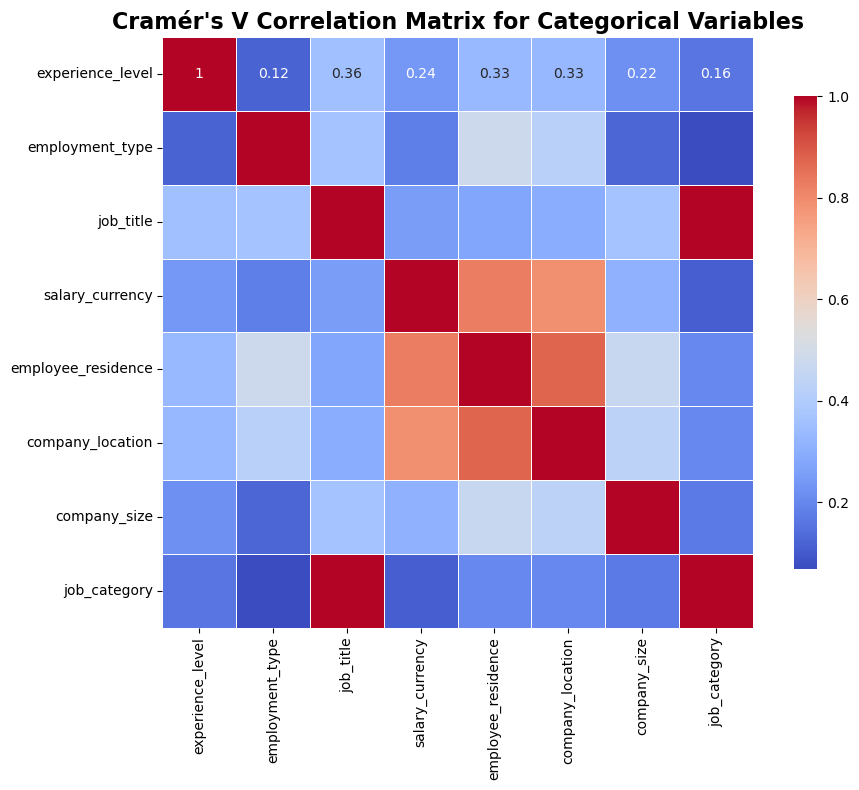

In [49]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Ensure that categorical columns selected
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Initialize an empty DataFrame to hold Cramér's V values
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            confusion_matrix = pd.crosstab(data[col1], data[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Plotting the Cramér's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

plt.title("Cramér's V Correlation Matrix for Categorical Variables", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = data[numerical_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data["feature"] = numerical_columns

vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

         feature       VIF
0      work_year  1.115404
1         salary  1.010582
2  salary_in_usd  2.710068
3   remote_ratio  1.053523
4  salary_binary  2.651033


In [51]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_binary,job_category
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,0,Other
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,0,Machine Learning
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,0,Machine Learning
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,1,Data Science
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,0,Data Science


In [52]:
data.drop(['salary_in_usd','salary_currency'],axis=1,inplace= True)

In [53]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,employee_residence,remote_ratio,company_location,company_size,salary_binary,job_category
0,2023,SE,FT,Principal Data Scientist,80000,ES,100,ES,L,0,Other
1,2023,MI,CT,ML Engineer,30000,US,100,US,S,0,Machine Learning
2,2023,MI,CT,ML Engineer,25500,US,100,US,S,0,Machine Learning
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M,1,Data Science
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M,0,Data Science


In [54]:
data.drop(['job_title'],axis=1,inplace= True)

In [55]:
data = pd.get_dummies(data,columns=['experience_level', 'employment_type', 'employee_residence', 'company_location', 'company_size','job_category'],dtype=int)

In [56]:
data.head()

,work_year,salary,remote_ratio,salary_binary,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,...,company_location_VN,company_size_L,company_size_M,company_size_S,job_category_Data Architecture,job_category_Data Engineering,job_category_Data Science,job_category_Machine Learning,job_category_Management,job_category_Other
0,2023,80000,100,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2023,30000,100,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,2023,25500,100,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,2023,175000,100,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,2023,120000,100,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


In [57]:
X = data.drop('salary_binary',axis=1)
y = data['salary_binary']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [58]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import xgboost as xgb

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

models = {
    'Logistic': LogisticRegression(), 
    'Ridge': LogisticRegression(penalty='l2', C=1.0), 
    'Lasso': LogisticRegression(penalty='l1', C=1, solver='saga'),
    'Elastic-net': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1, solver='saga'), 
    'Random Forest': RandomForestClassifier(), 
    'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True)
}

for name, model in models.items(): 
    # Fit model on training data
    model.fit(X_train, y_train)
    
    # Training predictions and metrics
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_cm = confusion_matrix(y_train, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0
    
    # Test predictions and metrics
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0
    
    # Print results
    print(name)
    print('=' * len(name))
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n' + '='*30 + '\n')



Logistic
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000


Ridge
=====
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000




C:\Users\nipun\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso
=====
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000




C:\Users\nipun\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elastic-net
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000


Random Forest
Training Accuracy: 1.0000
Training Error Rate: 0.0000
Training F1 Score: 1.0000
Training Confusion Matrix:
[[1063    0]
 [   0 1004]]
Training Sensitivity: 1.0000
Training Specificity: 1.0000


Test Accuracy: 0.9845
Test Error Rate: 0.0155
Test F1 Score: 0.9845
Test Confusion Matrix:
[[264   2]
 [  6 245]]
Test Sensitivity: 0.9761
Test Specificity: 0.9925


GaussianNB
Training Accuracy: 0.5399
Training Error Rate: 0.4601
Training F1 Score: 0.4370
Training Confusion Matrix:
[[128 935]
 [ 16 988]]
Training Sensitivity: 0.9841
Training Specificity: 0.1204


Test Accuracy: 0.5416
Test Error Rate: 0.4584
Test F1

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore')

# Define models with parameter grids for hyperparameter tuning
model_params = {
    'Logistic': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs']
        }
    },
    'Ridge': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs']
        }
    },
    'Lasso': {
        'model': LogisticRegression(solver='saga'),
        'params': {
            'penalty': ['l1'],
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'Elastic-net': {
        'model': LogisticRegression(solver='saga'),
        'params': {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7]
        }
    }
}

# Loop through each model and perform hyperparameter tuning with GridSearchCV
for name, model_dict in model_params.items():
    print(f"Training {name} with hyperparameter tuning...")
    grid_search = GridSearchCV(model_dict['model'], model_dict['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Training predictions and metrics
    train_pred = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_train, train_pred, average='weighted')
    train_cm = confusion_matrix(y_train, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0
    
    # Test predictions and metrics
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0
    
    # Print results
    print(name)
    print('=' * len(name))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n' + '='*30 + '\n')


Training Logistic with hyperparameter tuning...
Logistic
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000


Training Ridge with hyperparameter tuning...
Ridge
=====
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Accuracy: 0.5143
Training Error Rate: 0.4857
Training F1 Score: 0.3493
Training Confusion Matrix:
[[1063    0]
 [1004    0]]
Training Sensitivity: 0.0000
Training Specificity: 1.0000


Test Accuracy: 0.5145
Test Error Rate: 0.4855
Test F1 Score: 0.3496
Test Confusion Matrix:
[[266   0]
 [251   0]]
Test Sensitivity: 0.0000
Test Specificity: 1.0000


Training Lasso with hyperparameter t